In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from PenultimateFRP import CopolymerizationModel
%load_ext autoreload
%autoreload 2

# Define the full model function
def model(t, kd, f, kpAA, kpAB, kpBA, kpBB, 
     kdAA, kdAB, kdBA, kdBB,
     ktcAA, ktcAB, ktcBB,
     ktdAA, ktdAB, ktdBB): 
    k = [kd, f, 
     kpAA, kpAB, kpBA, kpBB, 
     kdAA, kdAB, kdBA, kdBB,
     ktcAA, ktcAB, ktcBB,
     ktdAA, ktdAB, ktdBB]
    
    y0[0] = 0.001
    y0[2] = 0.5
    y0[3] = 0.5
    cm3 = CopolymerizationModel(k, y0, t_span)
    # print(cm3.sol)

    fit_data = np.concatenate((cm3.xA, cm3.xB))
    
    if np.isnan(fit_data).any():
       k_params = {
           1
        'kd': kd, 'f': f,
        'kpAA': kpAA, 'kpAB': kpAB, 'kpBA': kpBA, 'kpBB': kpBB,
        'kdAA': kdAA, 'kdAB': kdAB, 'kdBA': kdBA, 'kdBB': kdBB,
        'ktcAA': ktcAA, 'ktcAB': ktcAB, 'ktcBB': ktcBB,
        'ktdAA': ktdAA, 'ktdAB': ktdAB, 'ktdBB': ktdBB
        }
       print(k_params)
    
    return fit_data

# Modified function factory
def create_wrapper(model_func, fixed_params, initial_guesses):
    fit_params = [p for p in initial_guesses if p not in fixed_params]
    fit_guesses = [initial_guesses[p] for p in fit_params]

    bounds = {}
    for key, value in zip(fit_params, fit_guesses):
        bounds[key] = (0, 1e3 * value)
    
    keys = list(bounds.keys())
    values = list(bounds.values())

    #Initialize lower bounds and upper bounds lists
    lower_bounds = [bound[0] for bound in values]
    upper_bounds = [bound[1] for bound in values]

    # Convert the lists to tuples
    fit_bounds = (lower_bounds, upper_bounds)
    # print('fit_bounds', fit_bounds)

    def fit_func(x, *args):
        params = {key: value for key, value in zip(fit_params, args)}
        params.update(fixed_params)
        #print(params)
        return model_func(x, **params)
    
    return fit_func, fit_guesses, fit_bounds

# Example usage:


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
# Initiation rate constant
kd    = 1e+10
f     = 0.5

# Propagation rate constants
kpAA = 10.0
kpAB = 2.0
kpBA = 20.0
kpBB = 10.0

# Depropagation rate constants
# kdAA = 5.0
# kdAB = 1.0
# kdBA = 10.0
# kdBB = 5.0
kdAA = 0.0
kdAB = 0.0
kdBA = 0.0
kdBB = 0.0
kdf = 0.5
kdAA = kdf*kpAA
kdAB = kdf*kpAB
kdBA = kdf*kpBA
kdBB = kdf*kpBB

# Termination by combination rate constants
# ktcAA = 2*1.5e+08
# ktcAB = 2*5.0e+07
# ktcBB = 2*1.5e+07
ktcAA = 0
ktcAB = 0
ktcBB = 0

# Termination by disproportionation rate constants
ktdAA = 0*2*9.0e+06     
ktdAB = 0*2*1.5e+07
ktdBB = 0*2*2.0e+07

k_params = {
     'kd': kd, 'f': f,
     'kpAA': kpAA, 'kpAB': kpAB, 'kpBA': kpBA, 'kpBB': kpBB,
     'kdAA': kdAA, 'kdAB': kdAB, 'kdBA': kdBA, 'kdBB': kdBB,
     'ktcAA': ktcAA, 'ktcAB': ktcAB, 'ktcBB': ktcBB,
     'ktdAA': ktdAA, 'ktdAB': ktdAB, 'ktdBB': ktdBB
}

In [134]:
# Data for fitting
num_points = 40
t_span = [0, 500]
t = np.linspace(t_span[0], t_span[1], num_points)
t = np.concatenate((t, t))
# t = np.concatenate((t, t, t, t, t, t, t, t, t, t, t, t, t, t, t, t, t, t, t, t))


y0 = np.zeros(11)
y0[0] = 0.005
y0[2] = 0.5
y0[3] = 0.5

In [135]:
y = model(t, **k_params)
rng = np.random.default_rng()
y_noise = 0.00 *rng.normal(size=t.size)
y_exp = y + y_noise

In [136]:
# Initial guesses for all parameters
initial_guesses = k_params.copy()
# initial_guesses['kpAA'] = 1e1
# initial_guesses['kpAB'] = 1e1
# initial_guesses['kpBA'] = 1e1
# initial_guesses['kpBB'] = 1e1
# initial_guesses['kdAA'] = 0.5e1
# initial_guesses['kdAB'] = 0.5e1
# initial_guesses['kdBA'] = 0.5e1
# initial_guesses['kdBB'] = 0.5e1
initial_guesses['kpAA'] = 20 # kpAA
initial_guesses['kpAB'] = 20 # kpAB
initial_guesses['kpBA'] = 20 # kpBA
initial_guesses['kpBB'] = 20 # kpBB
# initial_guesses['kdAA'] = kdAA
# initial_guesses['kdAB'] = kdAB
# initial_guesses['kdBA'] = kdBA
initial_guesses['kdBB'] = kdBB
# initial_guesses['ktdAA'] = 1e6
# initial_guesses['ktdBB'] = 1e6

# Parameters to keep constant (e.g., b=1.3)
fixed_params = {'kd': kd, 'f': f, 'ktcAA': ktcAA, 'ktcAB': ktcAB, 'ktcBB': ktcBB, 'ktdAB':ktdAB, 'ktdAA':ktdAA, 'ktdBB':ktdBB, 'ktdBB':ktdBB, 'kdAA': kdAA, 'kdAB': kdAB, 'kdBA': kdBA}
# fixed_params = {'kd': kd, 'f': f, 'ktcAA': ktcAA, 'ktcAB': ktcAB, 'ktcBB': ktcBB, 'ktdAB':ktdAB, 'ktdAA':ktdAA, 'ktdBB':ktdBB, 'ktdBB':ktdBB, 'kdAA': kdAA, 'kdAB': kdAB, 'kdBA': kdBA, 'kdBB': kdBB}   
# fixed_params = {'kd': kd, 'f': f, 'ktcAA': ktcAA, 'ktcAB': ktcAB, 'ktcBB': ktcBB, 'ktdAB':ktdAB, 'ktdAA':ktdAA, 'ktdBB':ktdBB, 'ktdBB':ktdBB, 'kdAA': kdAA, 'kdAB': kdAB, 'kdBA': kdBA}   

# fixed_params = {'kd': kd, 'f': f, 'kdAA': kdAA, 'kdAB': kdAB, 'kdBA': kdBA, 'ktcAA': ktcAA, 'ktcAB': ktcAB, 'ktcBB': ktcBB, 'ktdAB':ktdAB}

fit_params = [p for p in initial_guesses if p not in fixed_params]
adjusted_guesses = [initial_guesses[p] for p in fit_params]
#print(unfixed_params)
print(adjusted_guesses)
print(np.shape(fit_params))

[20, 20, 20, 20, 5.0, 1.0, 10.0, 5.0]
(8,)


In [137]:
#Create wrapper function and adjusted guesses
wrapper_function, fit_guesses, fit_bounds = create_wrapper(model, fixed_params, initial_guesses)

# Fit the model using the wrapper function
params, cov, infodict, errmsg, ier = curve_fit(wrapper_function, t, y_exp, method='trf', loss='soft_l1', p0=fit_guesses, bounds=fit_bounds, verbose=2, full_output=True, xtol=1e-15, ftol=1e-15, gtol=1e-15)

# Count the number of iterations
num_iterations = infodict['nfev']
print("Number of iterations:", num_iterations)

final_params = {}
counter = 0

for key in k_params:
    if key in fixed_params:
        final_params[key] = fixed_params[key]
        continue
    else:
        final_params[key] = params[counter]
        counter += 1

print(final_params)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4531e+00                                    4.24e+02    
       1              2         3.1473e-02      1.42e+00       2.78e+01       1.71e+02    
       2              3         9.2802e-03      2.22e-02       1.22e+01       6.34e+01    
       3              6         5.2241e-03      4.06e-03       4.01e+00       5.15e+01    
       4              8         4.5973e-03      6.27e-04       1.58e+00       1.72e+01    
       5              9         4.2646e-03      3.33e-04       2.18e+00       5.86e+01    
       6             11         4.1300e-03      1.35e-04       3.99e-01       4.07e+00    
       7             12         4.1060e-03      2.40e-05       1.21e-01       2.01e+00    
       8             13         4.0776e-03      2.83e-05       1.67e-01       1.71e+00    
       9             14         4.0454e-03      3.22e-05       3.92e-01       5.90e+00    

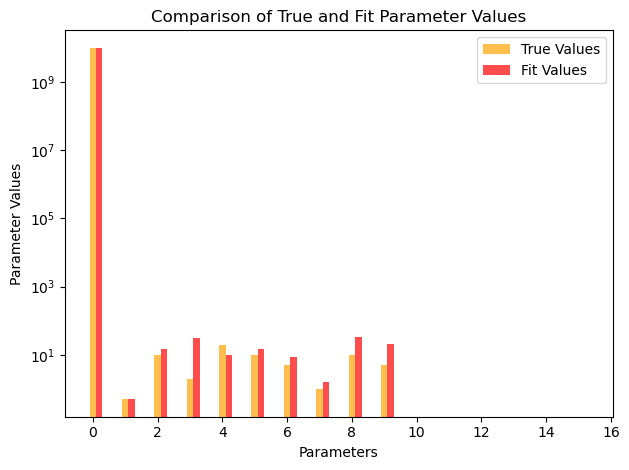

In [138]:
bar_width = 0.2
index = np.arange(len(k_params))

# Plot the true values (in blue) and the optimized values (in red)
plt.bar(index, k_params.values(), bar_width, label='True Values', color='orange', alpha=0.7)
plt.bar(index + bar_width, final_params.values(), bar_width, label='Fit Values', color='red', alpha=0.7)
plt.yscale("log")
# plt.ylim(top=5e4)

# Customize the plot
plt.xlabel('Parameters')
plt.ylabel('Parameter Values')
plt.title('Comparison of True and Fit Parameter Values')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

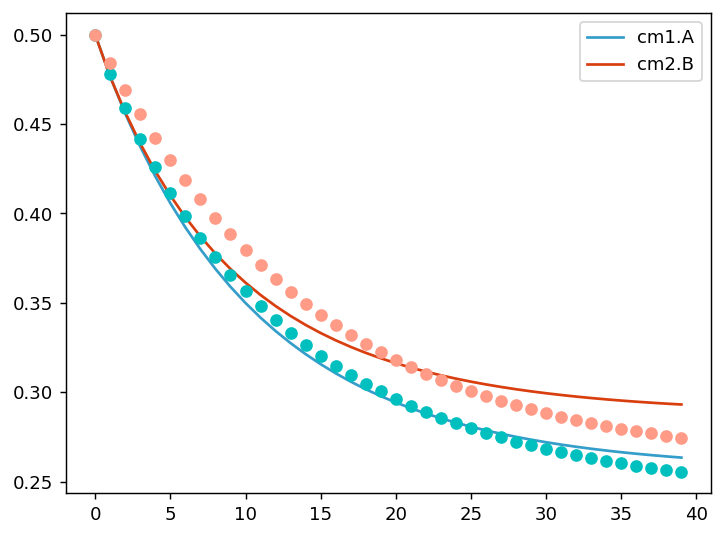

In [139]:
true_results = model(t, **k_params)
fitted_results = model(t, **final_params)

plt.figure(dpi=130)
plt.plot(fitted_results[0:num_points], color='#349dc9', label='cm1.A')
plt.plot(fitted_results[num_points:2*num_points], color='#d93e0f', label='cm2.B')
plt.legend()

plt.plot(true_results[0:num_points], 'o', color='c')
plt.plot(true_results[num_points:2*num_points], 'o', color='#ff9b87')


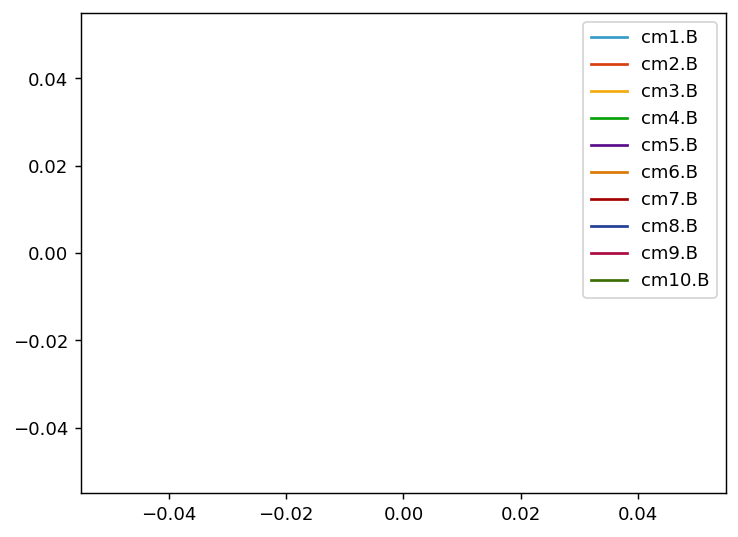

In [109]:
true_results = model(t, **k_params)
fitted_results = model(t, **final_params)

plt.figure(dpi=130)
plt.plot(fitted_results[10*num_points:11*num_points], color='#349dc9', label='cm1.B')
plt.plot(fitted_results[11*num_points:12*num_points], color='#d93e0f', label='cm2.B')
plt.plot(fitted_results[12*num_points:13*num_points], color='#f2aa0f', label='cm3.B')
plt.plot(fitted_results[13*num_points:14*num_points], color='#08a108', label='cm4.B')
plt.plot(fitted_results[14*num_points:15*num_points], color='#580c8a', label='cm5.B')
plt.plot(fitted_results[15*num_points:16*num_points], color='#db7902', label='cm6.B')
plt.plot(fitted_results[16*num_points:17*num_points], color='#a30000', label='cm7.B')
plt.plot(fitted_results[17*num_points:18*num_points], color='#233e94', label='cm8.B')
plt.plot(fitted_results[18*num_points:19*num_points], color='#ab093f', label='cm9.B')
plt.plot(fitted_results[19*num_points:20*num_points], color='#3c6e03', label='cm10.B')
plt.legend()

plt.plot(true_results[10*num_points:11*num_points], 'o', color='c')
plt.plot(true_results[11*num_points:12*num_points], 'o', color='#ff9b87')
plt.plot(true_results[12*num_points:13*num_points], 'o', color='#ffe987')
plt.plot(true_results[13*num_points:14*num_points], 'o', color='#54de69')
plt.plot(true_results[14*num_points:15*num_points], 'o', color='#d190fc')
plt.plot(true_results[15*num_points:16*num_points], 'o', color='#ffb152')
plt.plot(true_results[16*num_points:17*num_points], 'o', color='#f04d4d')
plt.plot(true_results[17*num_points:18*num_points], 'o', color='#5977d9')
plt.plot(true_results[18*num_points:19*num_points], 'o', color='#eb5788')
plt.plot(true_results[19*num_points:20*num_points], 'o', color='#87d132')

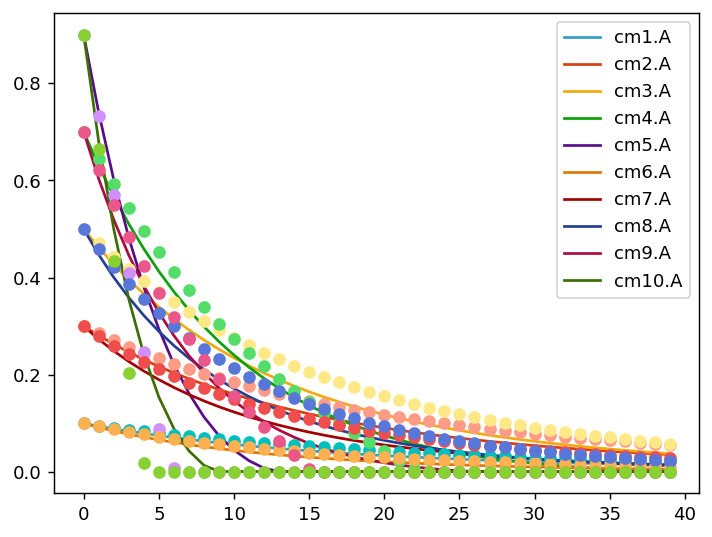

In [601]:
true_results = model(t, **k_params)
fitted_results = model(t, **final_params)

plt.figure(dpi=130)
plt.plot(fitted_results[0:num_points], color='#349dc9', label='cm1.A')
plt.plot(fitted_results[num_points:2*num_points], color='#d93e0f', label='cm2.A')
plt.plot(fitted_results[2*num_points:3*num_points], color='#f2aa0f', label='cm3.A')
plt.plot(fitted_results[3*num_points:4*num_points], color='#08a108', label='cm4.A')
plt.plot(fitted_results[4*num_points:5*num_points], color='#580c8a', label='cm5.A')
plt.plot(fitted_results[5*num_points:6*num_points], color='#db7902', label='cm6.A')
plt.plot(fitted_results[6*num_points:7*num_points], color='#a30000', label='cm7.A')
plt.plot(fitted_results[7*num_points:8*num_points], color='#233e94', label='cm8.A')
plt.plot(fitted_results[8*num_points:9*num_points], color='#ab093f', label='cm9.A')
plt.plot(fitted_results[9*num_points:10*num_points], color='#3c6e03', label='cm10.A')
plt.legend()

plt.plot(true_results[0:num_points], 'o', color='c')
plt.plot(true_results[num_points:2*num_points], 'o', color='#ff9b87')
plt.plot(true_results[2*num_points:3*num_points], 'o', color='#ffe987')
plt.plot(true_results[3*num_points:4*num_points], 'o', color='#54de69')
plt.plot(true_results[4*num_points:5*num_points], 'o', color='#d190fc')
plt.plot(true_results[5*num_points:6*num_points], 'o', color='#ffb152')
plt.plot(true_results[6*num_points:7*num_points], 'o', color='#f04d4d')
plt.plot(true_results[7*num_points:8*num_points], 'o', color='#5977d9')
plt.plot(true_results[8*num_points:9*num_points], 'o', color='#eb5788')
plt.plot(true_results[9*num_points:10*num_points], 'o', color='#87d132')


$\text{Adressing the no infs or nans error}$

In [602]:
k_error = {'kd': 3e-06, 'f': 0.5, 'kpAA': 3979.1260205436547, 'kpAB': 9065.484855593399, 'kpBA': 272.6775687809096, 'kpBB': 114.5748795368038, 'kdAA': 0, 'kdAB': 0, 'kdBA': 0, 'kdBB': 3.5038937683137257, 'ktcAA': 0, 'ktcAB': 0, 'ktcBB': 0, 'ktdAA': 678.3689170386152, 'ktdAB': 30000000.0, 'ktdBB': 10255241.469843786}
k_error = k_error.values()

y0[0] = 0.005
y0[2] = 0.9
y0[3] = 0.1
cm5 = CopolymerizationModel(k_error, y0, t_span)

In [603]:
cm5.mom_sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-10 ...  1.805e+05  2.160e+05]
        y: [[ 5.000e-03  5.000e-03 ...  4.273e-03  4.273e-03]
            [ 0.000e+00  1.500e-18 ...  3.215e-09  3.215e-09]
            ...
            [ 0.000e+00  1.402e-36 ...  3.177e-19  3.175e-19]
            [ 0.000e+00  1.307e-65 ...  4.428e-04  4.428e-04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1489
     njev: 115
      nlu: 259

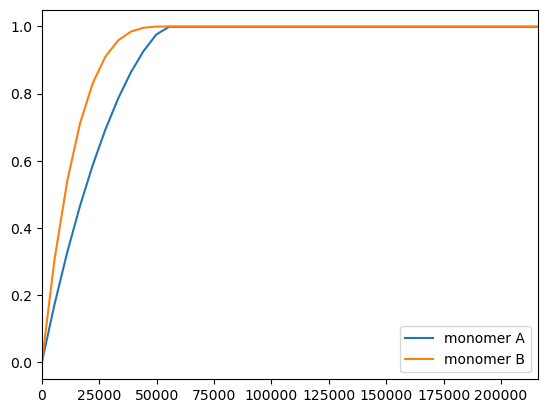

In [604]:
plt.plot(cm5.t, cm5.xA, label='monomer A')
plt.plot(cm5.t, cm5.xB, label='monomer B')
plt.xlim(t_span)
plt.legend()

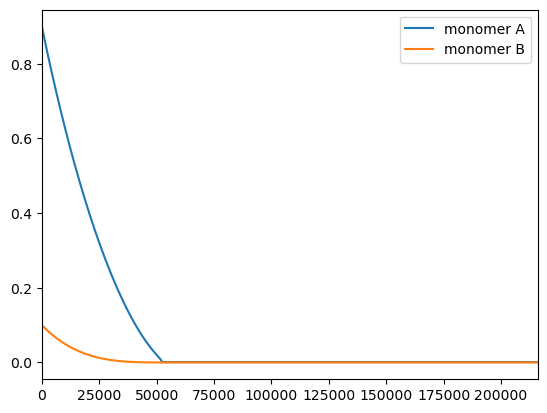

In [605]:
plt.plot(cm5.mom_sol.t, cm5.mom_sol.y[2], label='monomer A')
plt.plot(cm5.mom_sol.t, cm5.mom_sol.y[3], label='monomer B')
plt.xlim(t_span)
plt.legend()

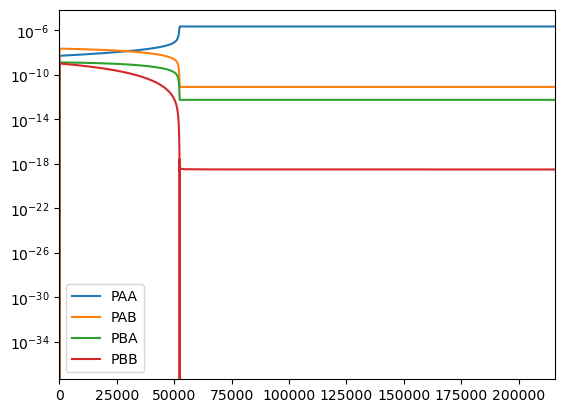

In [606]:
plt.plot(cm5.mom_sol.t, cm5.mom_sol.y[6], label='PAA')
plt.plot(cm5.mom_sol.t, cm5.mom_sol.y[7], label='PAB')
plt.plot(cm5.mom_sol.t, cm5.mom_sol.y[8], label='PBA')
plt.plot(cm5.mom_sol.t, cm5.mom_sol.y[9], label='PBB')
plt.xlim(t_span)
plt.yscale('log')
plt.legend()

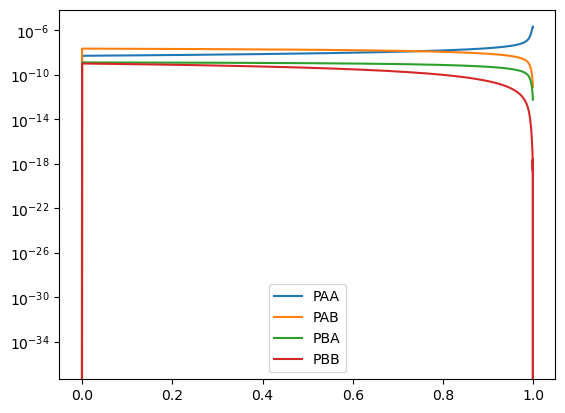

In [607]:
x  = (cm5.A0 + cm5.B0 - cm5.mom_sol.y[2] - cm5.mom_sol.y[3]) / (cm5.A0 + cm5.B0)

plt.plot(x, cm5.mom_sol.y[6], label='PAA')
plt.plot(x, cm5.mom_sol.y[7], label='PAB')
plt.plot(x, cm5.mom_sol.y[8], label='PBA')
plt.plot(x, cm5.mom_sol.y[9], label='PBB')
plt.yscale('log')
plt.legend()

array([ 0.00000000e+00,  1.40230865e-36,  6.04712443e-36,  1.78790984e-33,
        7.19705673e-33,  1.83440213e-30,  7.33966547e-30,  1.87765137e-27,
        7.55242180e-27,  2.26588875e-24,  9.54755322e-24,  5.98627489e-21,
        2.84992044e-20,  3.14093031e-17,  1.47777591e-16,  4.55875067e-14,
        1.59447661e-13,  2.59950337e-12,  5.83026415e-12,  1.79469166e-11,
        3.05334160e-11,  4.29110272e-11,  7.23457740e-11,  1.01562725e-10,
        1.30741026e-10,  1.59716376e-10,  2.19795926e-10,  2.78468240e-10,
        3.35426108e-10,  3.90373291e-10,  4.96243702e-10,  5.91185842e-10,
        6.57647088e-10,  7.16981767e-10,  7.69419218e-10,  8.15345032e-10,
        8.55249970e-10,  9.17553967e-10,  9.46558144e-10,  9.70585228e-10,
        9.90395961e-10,  1.00666718e-09,  1.01998714e-09,  1.03086070e-09,
        1.04224613e-09,  1.05089086e-09,  1.05743884e-09,  1.06238873e-09,
        1.06612462e-09,  1.06894090e-09,  1.07156954e-09,  1.07338951e-09,
        1.07464784e-09,  

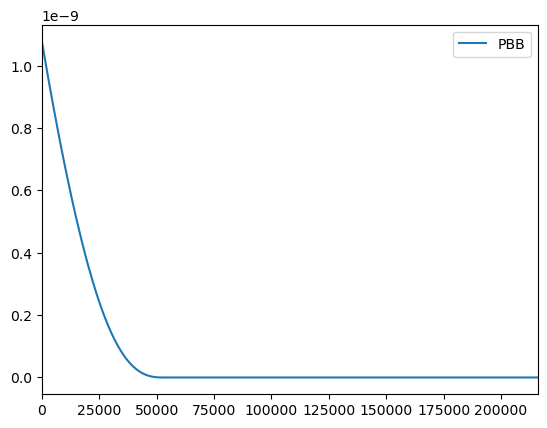

In [608]:
plt.plot(cm5.mom_sol.t, cm5.mom_sol.y[9], label='PBB')
plt.xlim(t_span)
plt.legend()

cm5.mom_sol.y[9]